# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [2.1 Tokenisation](#PREPROCESS_tokenized)
    * [2.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [2.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [2.4 Comparaison des scores](#PREPROCESS_scores)
* [3. Recherche du `plongement` le plus adapté](#EMBEDDING)
    * [3.1 Word2Vec](#EMBEDDING_Word2Vec)
    * [3.2 FastText](#EMBEDDING_FastText)
    * [3.3 Comparaison des scores](#EMBEDDING_scores)
* [4. Recherche du `modèle` de classification le plus adapté](#CLF)

In [1]:
import os
import time
import pathlib

import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
try:
    from keras.utils import pad_sequences
except ImportError:
    from keras.preprocessing.sequence import pad_sequences

import joblib

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-02 17:30:58.594847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [2]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN_SelectPreprocessing.csv")

#### Définissons les fonctions génériques de notre Spot Checking 

In [3]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [4]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [5]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=10,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

#### Définissons une méthode de `cross-validation`

In [7]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

#### Définissons la taille de batch utilisé

In [8]:
batch_size = 8192 # 4096

---
---
# 2. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

Pour rechercher le pré-traitement le plus adapté, nous allons essayer différents jeux de données préparés lors de l'EDA.
Mais pour éviter tout autre changement, nous allons dans un premier temps définir une architecture NN simple et un Embedding de base que nous allons utiliser pour comparer l'influence des différents pré-traitement.

In [9]:
def architecture01(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

### Chargeons le jeu de données avec toutes les étapes de pré-processing faites dans 01_EDA.ipynb

In [10]:
data_full = pd.read_csv(pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'))
display(data_full.head(), data_full.shape)

,target,text,text_clean,tokens,tokens_filtered_advanced,tokens_filtered_simple,lemmas_filtered_advanced,lemmas_filtered_simple,lemmas_not_filtered
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","$URL$ - Awww, that's a bummer. You shoulda got...","$ url$ - awww , that 's a bummer . you shoulda...",bummer shoulda got day d,bummer shoulda got day d,bummer shoulda get day d,bummer shoulda get day d,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he ca n't update his facebook by...,upset update facebook texting cry result schoo...,upset update facebook texting cry result schoo...,upset update facebook texte cry result school ...,upset update facebook texte cry result school ...,be upset that he can not update his facebook b...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to sa...,i dived many times for the ball . managed to s...,dived times ball managed save 50 % rest bounds,dived times ball managed save 50 % rest bounds,dive time ball manage save 50 % rest bound,dive time ball manage save 50 % rest bound,I dive many time for the ball . manage to save...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,body feels itchy like fire,body feels itchy like fire,body feel itchy like fire,body feel itchy like fire,my whole body feel itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am ...","no , it 's not behaving at all . i 'm mad . wh...",behaving mad,behaving mad,behave mad,behave mad,"no , it be not behave at all . I be mad . why ..."


(1452791, 9)

### Préparons les jeux de données des differents pré-processing

In [11]:
data_raw = data_full[['target','text']]
print("\n", " DATA RAW ".center(55, '-'))
display(data_raw.head(2), data_raw.shape)

data_preprocess_01 = data_full[['target','text_clean']]
print("\n", " DATA TWITTER-PREPROCESS ".center(55, '-'))
display(data_preprocess_01.head(2), data_preprocess_01.shape)

data_preprocess_02 = data_full[['target','tokens']]
print("\n", " DATA SpaCy TOKENS ".center(55, '-'))
display(data_preprocess_02.head(2), data_preprocess_02.shape)

data_preprocess_03 = data_full[['target','tokens_filtered_advanced']]
print("\n", " DATA SpaCy FILTERED TOKENS ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_03_simple = data_full[['target','tokens_filtered_simple']]
print("\n", " DATA SpaCy FILTERED TOKENS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_04 = data_full[['target','lemmas_filtered_advanced']]
print("\n", " DATA SpaCy LEMMAS ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)

data_preprocess_04_simple = data_full[['target','lemmas_filtered_simple']]
print("\n", " DATA SpaCy LEMMAS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)

data_preprocess_04_nofilter = data_full[['target','lemmas_not_filtered']]
print("\n", " DATA SpaCy LEMMAS (SANS filtrage) ".center(55, '-'))
display(data_preprocess_04_nofilter.head(2), data_preprocess_04_nofilter.shape)


 ----------------------- DATA RAW ----------------------


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)


 --------------- DATA TWITTER-PREPROCESS ---------------


,target,text_clean
0,0,"$URL$ - Awww, that's a bummer. You shoulda got..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)


 ------------------ DATA SpaCy TOKENS ------------------


,target,tokens
0,0,"$ url$ - awww , that 's a bummer . you shoulda..."
1,0,is upset that he ca n't update his facebook by...


(1452791, 2)


 -------------- DATA SpaCy FILTERED TOKENS -------------


,target,tokens_filtered_advanced
0,0,bummer shoulda got day d
1,0,upset update facebook texting cry result schoo...


(1452791, 2)


 -- DATA SpaCy FILTERED TOKENS (avec filtrage simple) --


,target,tokens_filtered_advanced
0,0,bummer shoulda got day d
1,0,upset update facebook texting cry result schoo...


(1452791, 2)


 ------------------ DATA SpaCy LEMMAS ------------------


,target,lemmas_filtered_advanced
0,0,bummer shoulda get day d
1,0,upset update facebook texte cry result school ...


(1452791, 2)


 ------- DATA SpaCy LEMMAS (avec filtrage simple) ------


,target,lemmas_filtered_advanced
0,0,bummer shoulda get day d
1,0,upset update facebook texte cry result school ...


(1452791, 2)


 ---------- DATA SpaCy LEMMAS (SANS filtrage) ----------


,target,lemmas_not_filtered
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...


(1452791, 2)

### Définissons une fonction permattant de Tokenizer notre jeu de données

In [12]:
def preprocess_data_RAW(X_train, X_test, tokenizer_num_words=4500, padding_size=50, verbose=1):
    tokenizer = Tokenizer(num_words=tokenizer_num_words)
    tokenizer.fit_on_texts(X_train)

    dictionary = tokenizer.word_index
    vocab_size = len(dictionary)+1 # Adding 1 because of reserved 0 index
    
    X_train_enc = tokenizer.texts_to_sequences(X_train)
    X_test_enc = tokenizer.texts_to_sequences(X_test)
    
    X_train_ready = pad_sequences(X_train_enc, padding='post', maxlen=padding_size)
    X_test_ready = pad_sequences(X_test_enc, padding='post', maxlen=padding_size)
    
    # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    if verbose > 0:
        print("----- One sample outputs for demo -----")
        print(f">> Original sentence: {X_train.iloc[0]}\n")
        print(f">> Tokenized sentence: {tokenizer.sequences_to_texts(X_train_ready[:1])}\n")
        print(f">> X_train_enc: {X_train_enc[:1]}\n")
        print(f">> X_train_ready: {X_train_ready[:1]}")
        
        print(f"\nVocab size: {vocab_size}")
    
    return X_train_ready, X_test_ready, tokenizer, vocab_size

### Définissons une fonction pour préparer le corpus avec le nombre de tokens demandé puis entrainer le modèle avec ce corpus

In [39]:
def train_model(X_train_, X_test_, y_train_, y_test_, vocab_size_, preprocess_desc=""):
    
    print(f"Testing model with \"{preprocess_desc}\"".upper().center(100,"-"), end='\n\n')
    
    # Embedding simple
    padding_size = 50
    embedding_dim = 100
    embedding = layers.Embedding(input_dim=vocab_size_, output_dim=embedding_dim, input_length=padding_size, trainable=True)
    
    # Prepare model
    f_opti = keras.optimizers.Adam(learning_rate=0.0005)
    f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
    f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()
    
    model = architecture01(f_opti, f_loss, f_metrics, embedding)
    # archi01_model_RAW.summary()
    
    t0 = time.perf_counter()
    history = model.fit(
        x=X_train_, y=y_train_, 
        validation_data=(X_test_, y_test_), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"archi01_PREPROCESS_{preprocess_desc}"),
        verbose=1,
        # validation_split=0.2,
        # train_labels
    )
    train_time = time.perf_counter() - t0
    
    # Print accuracy scores
    loss, accuracy = model.evaluate(X_train_ready, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_ready, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    
    return history, model, train_time

---
## 2.1 RAW / Aucun pré-processing <a class="anchor" id="PREPROCESS_raw"></a> [⇪](#menu)

### Chargeons le jeu de données

In [14]:
display(data_raw.head(2), data_raw.shape)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_raw['text'], data_raw.target, test_size=0.2, random_state=random_seed)

In [16]:
display(X_train.head(2), X_train.shape)

317722    @shen88 You too are fake..  :X ... Disguising ...
37615                 my boss is still mad from me i guess 
Name: text, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [17]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: @shen88 You too are fake..  :X ... Disguising your links to be something else.

>> Tokenized sentence: ['you too are fake x your links to be something else']

>> X_train_enc: [[7, 46, 35, 1749, 186, 42, 1921, 2, 22, 209, 496]]

>> X_train_ready: [[   7   46   35 1749  186   42 1921    2   22  209  496    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 556150


### Entrainons notre modèle

In [23]:
history_RAW, model_RAW, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "RAW")

--------------------------------------TESTING MODEL WITH "RAW"--------------------------------------

Epoch 1/50
142/142 [==============================] - 91s 622ms/step - loss: 0.6188 - accuracy: 0.6532 - val_loss: 0.4610 - val_accuracy: 0.7917

Epoch 00001: val_accuracy improved from -inf to 0.79174, saving model to models/archi01_PREPROCESS_RAW.epoch01-accuracy0.79.hdf5
Epoch 2/50
142/142 [==============================] - 88s 617ms/step - loss: 0.4534 - accuracy: 0.7927 - val_loss: 0.4423 - val_accuracy: 0.7949

Epoch 00002: val_accuracy improved from 0.79174 to 0.79492, saving model to models/archi01_PREPROCESS_RAW.epoch02-accuracy0.79.hdf5
Epoch 3/50
142/142 [==============================] - 88s 620ms/step - loss: 0.4356 - accuracy: 0.7983 - val_loss: 0.4322 - val_accuracy: 0.7991

Epoch 00003: val_accuracy improved from 0.79492 to 0.79907, saving model to models/archi01_PREPROCESS_RAW.epoch03-accuracy0.80.hdf5
Epoch 4/50
142/142 [==============================] - 87s 614ms/ste

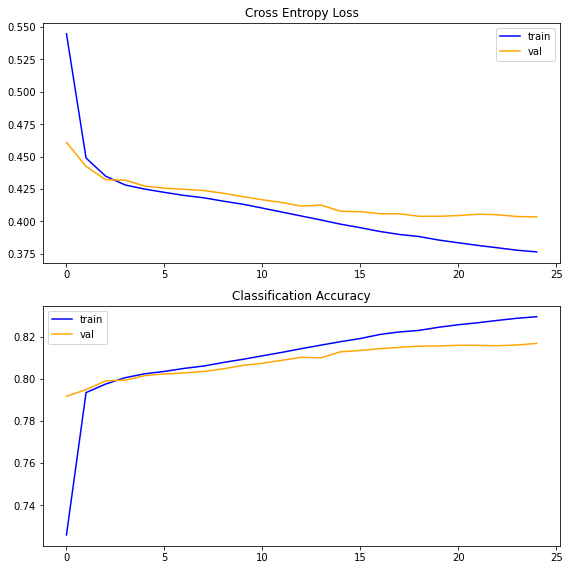

In [25]:
summarize_diagnostics(history_RAW)

### Affichons les scores du modèle

In [26]:
t0 = time.perf_counter()
y_preds_proba = model_RAW.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + Tokenizer4500) ---------------------------------------------------------------

             ROC_AUC : 0.8954
                  F1 : 0.8102
            ACCURACY : 0.8129
           PRECISION : 0.8169
              RECALL : 0.8036
   AVERAGE_PRECISION : 0.8958

       TRAINING-TIME : 2231.3216
      INFERENCE-TIME : 23.8486

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.81      0.82      0.82    146176
Prediction = 1       0.82      0.80      0.81    144383

      accuracy                           0.81    290559
     macro avg    

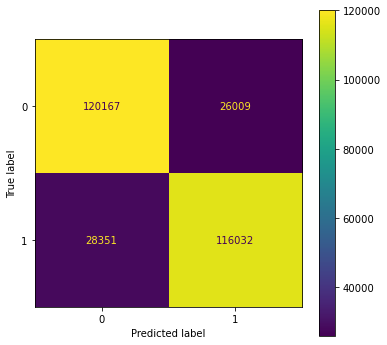

--- ROC AUC ---------------------------------------------------------------------------------------- 



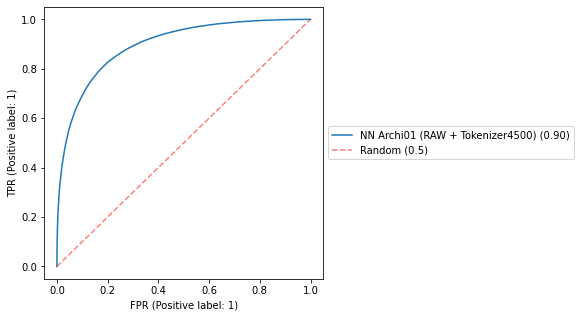

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



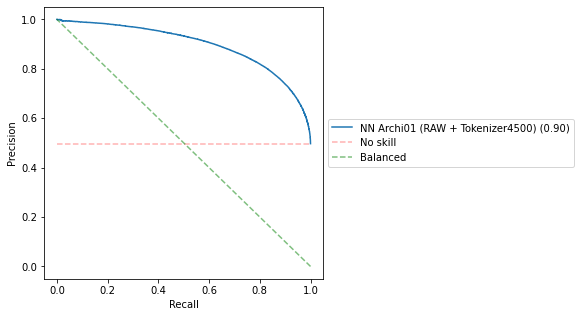

In [27]:
model_name = "NN Archi01 (RAW + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.2 Preprocessing 01 / Twitter-Preprocessor <a class="anchor" id="PREPROCESS_01"></a> [⇪](#menu)
> Pour ce jeu de données on à utiliser la librairie python [tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/) afin de supprimer les MENTIONS, les URL et mots réservés *(RT, FAV, ...)*

### Chargeons le jeu de données

In [28]:
display(data_preprocess_01.head(2), data_preprocess_01.shape)

,target,text_clean
0,0,"$URL$ - Awww, that's a bummer. You shoulda got..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_01['text_clean'], data_preprocess_01.target, test_size=0.2, random_state=random_seed)

In [56]:
display(X_train.head(2), X_train.shape)

317722    You too are fake.. :X ... Disguising your link...
37615                  my boss is still mad from me i guess
Name: text_clean, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [57]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: You too are fake.. :X ... Disguising your links to be something else.

>> Tokenized sentence: ['you too are fake x your links to be something else']

>> X_train_enc: [[7, 46, 35, 1730, 198, 42, 1886, 2, 22, 206, 489]]

>> X_train_ready: [[   7   46   35 1730  198   42 1886    2   22  206  489    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 261214


### Entrainons notre modèle

In [32]:
history_PP1, model_PP1, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP1")

--------------------------------------TESTING MODEL WITH "PP1"--------------------------------------

Epoch 1/50
142/142 [==============================] - 58s 391ms/step - loss: 0.6275 - accuracy: 0.6374 - val_loss: 0.4630 - val_accuracy: 0.7921

Epoch 00001: val_accuracy improved from -inf to 0.79214, saving model to models/archi01_PREPROCESS_PP1.epoch01-accuracy0.79.hdf5
Epoch 2/50
142/142 [==============================] - 55s 388ms/step - loss: 0.4566 - accuracy: 0.7931 - val_loss: 0.4452 - val_accuracy: 0.7953

Epoch 00002: val_accuracy improved from 0.79214 to 0.79527, saving model to models/archi01_PREPROCESS_PP1.epoch02-accuracy0.80.hdf5
Epoch 3/50
142/142 [==============================] - 55s 387ms/step - loss: 0.4399 - accuracy: 0.7974 - val_loss: 0.4359 - val_accuracy: 0.7965

Epoch 00003: val_accuracy improved from 0.79527 to 0.79654, saving model to models/archi01_PREPROCESS_PP1.epoch03-accuracy0.80.hdf5
Epoch 4/50
142/142 [==============================] - 55s 386ms/ste

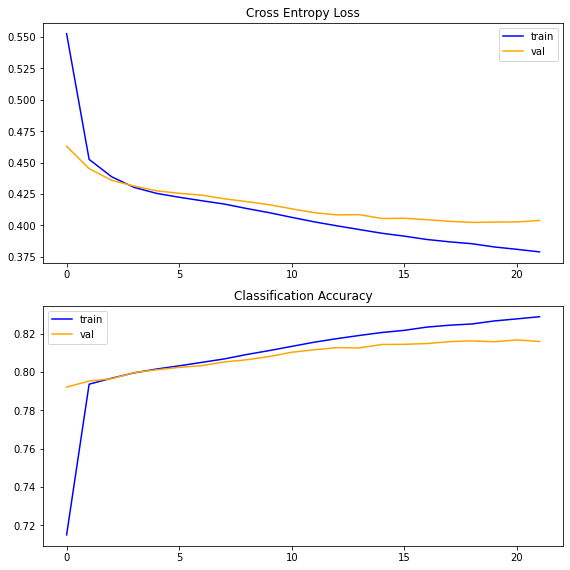

In [33]:
summarize_diagnostics(history_PP1)

### Affichons les scores du modèle

In [69]:
t0 = time.perf_counter()
y_preds_proba = model_PP1.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS01 + Tokenizer4500) ------------------------------------------------------

             ROC_AUC : 0.8940
                  F1 : 0.8086
            ACCURACY : 0.8116
           PRECISION : 0.8168
              RECALL : 0.8005
   AVERAGE_PRECISION : 0.8945

       TRAINING-TIME : 1195.0130
      INFERENCE-TIME : 23.6745

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.81      0.82      0.81    146176
Prediction = 1       0.82      0.80      0.81    144383

      accuracy                           0.81    290559
     macro avg    

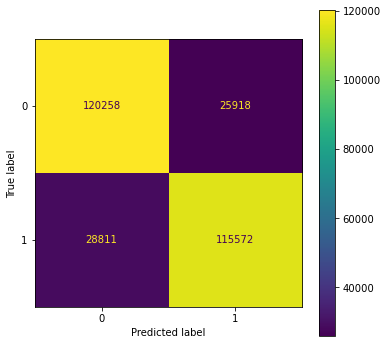

--- ROC AUC ---------------------------------------------------------------------------------------- 



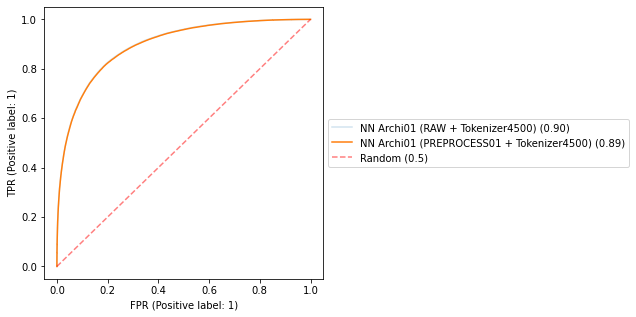

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



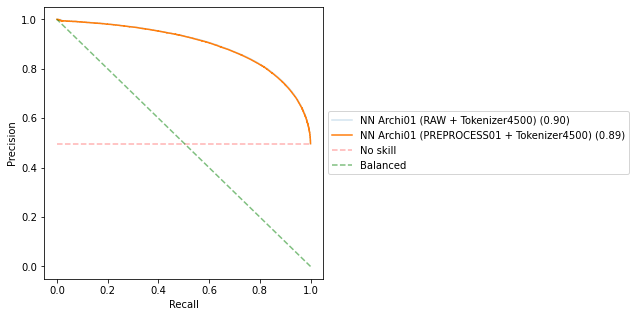

In [70]:
model_name = "NN Archi01 (PREPROCESS01 + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.3 Preprocessing 02 / SpaCy Tokenization <a class="anchor" id="PREPROCESS_02"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_01) que l'on a Tokenisé en utilisant SpaCy. On en a profité pour supprimer les espaces en début et fin de ligne et pour retirer les majuscules *(était-ce une bonne idée ?)*

### Chargeons le jeu de données

In [36]:
display(data_preprocess_02.head(2), data_preprocess_02.shape)

,target,tokens
0,0,"$ url$ - awww , that 's a bummer . you shoulda..."
1,0,is upset that he ca n't update his facebook by...


(1452791, 2)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_02['tokens'], data_preprocess_02.target, test_size=0.2, random_state=random_seed)

In [72]:
display(X_train.head(2), X_train.shape)

317722    you too are fake .. :x ... disguising your lin...
37615                  my boss is still mad from me i guess
Name: tokens, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [73]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: you too are fake .. :x ... disguising your links to be something else .

>> Tokenized sentence: ['you too are fake x your links to be something else']

>> X_train_enc: [[8, 48, 37, 1695, 201, 45, 1852, 2, 25, 210, 474]]

>> X_train_ready: [[   8   48   37 1695  201   45 1852    2   25  210  474    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 245063


### Entrainons notre modèle

In [43]:
history_PP2, model_PP2, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP2")

--------------------------------------TESTING MODEL WITH "PP2"--------------------------------------

Epoch 1/50
142/142 [==============================] - 56s 381ms/step - loss: 0.6140 - accuracy: 0.6573 - val_loss: 0.4637 - val_accuracy: 0.7908

Epoch 00001: val_accuracy improved from -inf to 0.79082, saving model to models/archi01_PREPROCESS_PP2.epoch01-accuracy0.79.hdf5
Epoch 2/50
142/142 [==============================] - 53s 375ms/step - loss: 0.4570 - accuracy: 0.7930 - val_loss: 0.4465 - val_accuracy: 0.7947

Epoch 00002: val_accuracy improved from 0.79082 to 0.79474, saving model to models/archi01_PREPROCESS_PP2.epoch02-accuracy0.79.hdf5
Epoch 3/50
142/142 [==============================] - 54s 377ms/step - loss: 0.4426 - accuracy: 0.7978 - val_loss: 0.4391 - val_accuracy: 0.7975

Epoch 00003: val_accuracy improved from 0.79474 to 0.79747, saving model to models/archi01_PREPROCESS_PP2.epoch03-accuracy0.80.hdf5
Epoch 4/50
142/142 [==============================] - 54s 379ms/ste

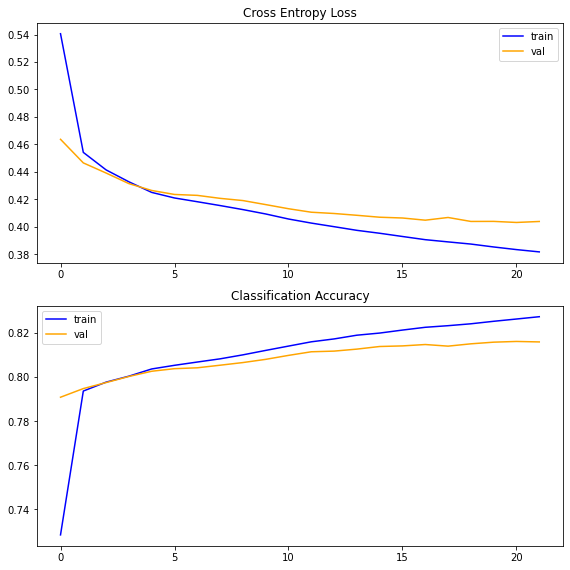

In [44]:
summarize_diagnostics(history_PP2)

### Affichons les scores du modèle

In [74]:
t0 = time.perf_counter()
y_preds_proba = model_PP2.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS02 + Tokenizer4500) ------------------------------------------------------

             ROC_AUC : 0.8938
                  F1 : 0.8089
            ACCURACY : 0.8114
           PRECISION : 0.8147
              RECALL : 0.8032
   AVERAGE_PRECISION : 0.8946

       TRAINING-TIME : 1195.0130
      INFERENCE-TIME : 24.1958

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.81      0.82      0.81    146176
Prediction = 1       0.81      0.80      0.81    144383

      accuracy                           0.81    290559
     macro avg    

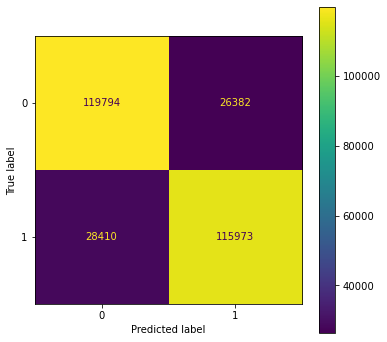

--- ROC AUC ---------------------------------------------------------------------------------------- 



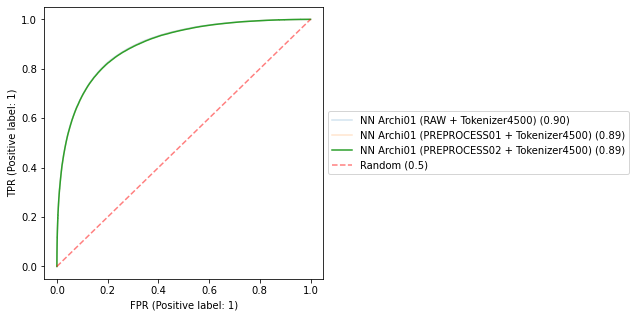

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



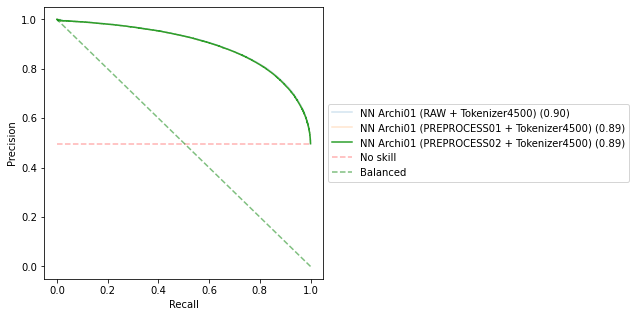

In [75]:
model_name = "NN Archi01 (PREPROCESS02 + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.4 Preprocessing 03 / SpaCy Filtering <a class="anchor" id="PREPROCESS_03"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_02) que l'on a Filtré en utilisant les pos tags des tokens SpaCy collecté précèdement.

### Chargeons le jeu de données

In [76]:
display(data_preprocess_03.head(2), data_preprocess_03.shape)

,target,tokens_filtered_advanced
0,0,bummer shoulda got day d
1,0,upset update facebook texting cry result schoo...


(1452791, 2)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_03['tokens_filtered_advanced'], data_preprocess_03.target, test_size=0.2, random_state=random_seed)

In [78]:
display(X_train.head(2), X_train.shape)

317722    fake disguising links
37615            boss mad guess
Name: tokens_filtered_advanced, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [79]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: fake disguising links

>> Tokenized sentence: ['fake links']

>> X_train_enc: [[1333, 1454]]

>> X_train_ready: [[1333 1454    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 196839


### Entrainons notre modèle

In [80]:
history_PP3, model_PP3, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP3")

--------------------------------------TESTING MODEL WITH "PP3"--------------------------------------

Epoch 1/50
142/142 [==============================] - 52s 351ms/step - loss: 0.6365 - accuracy: 0.6378 - val_loss: 0.5022 - val_accuracy: 0.7600

Epoch 00001: val_accuracy improved from -inf to 0.75998, saving model to models/archi01_PREPROCESS_PP3.epoch01-accuracy0.76.hdf5
Epoch 2/50
142/142 [==============================] - 49s 343ms/step - loss: 0.5004 - accuracy: 0.7606 - val_loss: 0.4979 - val_accuracy: 0.7610

Epoch 00002: val_accuracy improved from 0.75998 to 0.76103, saving model to models/archi01_PREPROCESS_PP3.epoch02-accuracy0.76.hdf5
Epoch 3/50
142/142 [==============================] - 49s 345ms/step - loss: 0.4955 - accuracy: 0.7633 - val_loss: 0.4965 - val_accuracy: 0.7617

Epoch 00003: val_accuracy improved from 0.76103 to 0.76172, saving model to models/archi01_PREPROCESS_PP3.epoch03-accuracy0.76.hdf5
Epoch 4/50
142/142 [==============================] - 49s 343ms/ste

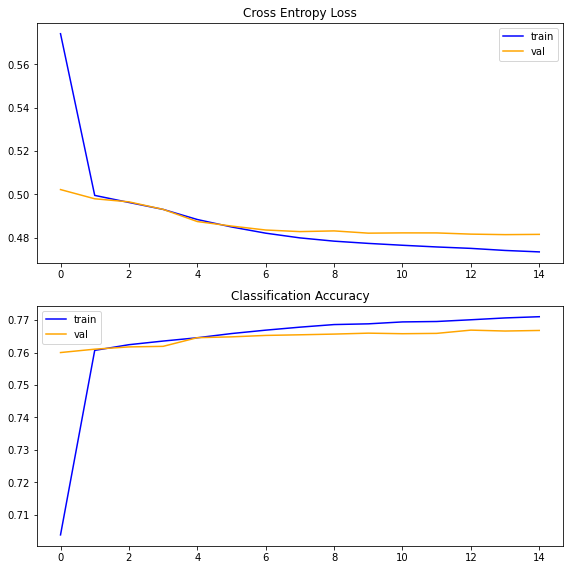

In [81]:
summarize_diagnostics(history_PP3)

### Affichons les scores du modèle

In [82]:
t0 = time.perf_counter()
y_preds_proba = model_PP3.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS03 + Tokenizer4500) ------------------------------------------------------

             ROC_AUC : 0.8450
                  F1 : 0.7648
            ACCURACY : 0.7646
           PRECISION : 0.7594
              RECALL : 0.7702
   AVERAGE_PRECISION : 0.8381

       TRAINING-TIME : 745.8879
      INFERENCE-TIME : 23.9321

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.76      0.76    146176
Prediction = 1       0.76      0.77      0.76    144383

      accuracy                           0.76    290559
     macro avg     

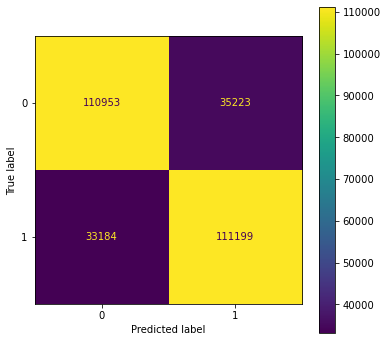

--- ROC AUC ---------------------------------------------------------------------------------------- 



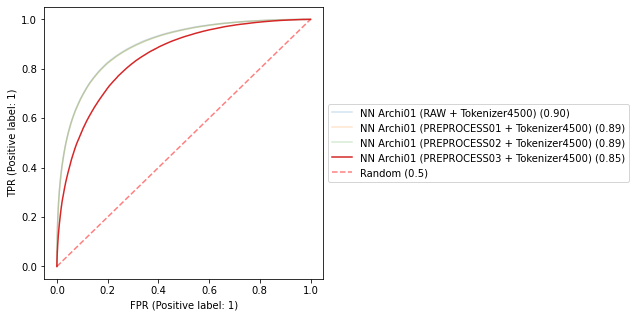

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



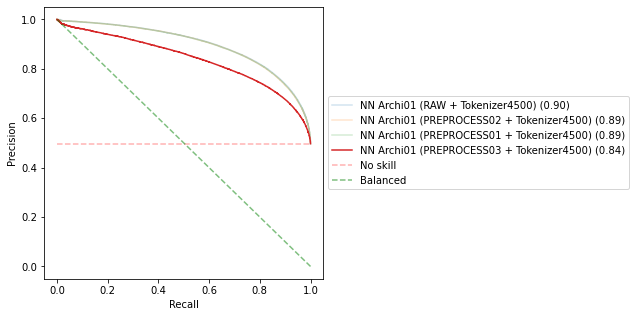

In [83]:
model_name = "NN Archi01 (PREPROCESS03 + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Testons la même chose avec le jeu de données qui a été filtré avec des règles plus simples

### Chargeons le jeu de données

In [84]:
display(data_preprocess_03_simple.head(2), data_preprocess_03_simple.shape)

,target,tokens_filtered_simple
0,0,bummer shoulda got day d
1,0,upset update facebook texting cry result schoo...


(1452791, 2)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_03_simple['tokens_filtered_simple'], data_preprocess_03_simple.target, test_size=0.2, random_state=random_seed)

In [86]:
display(X_train.head(2), X_train.shape)

317722    fake disguising links
37615            boss mad guess
Name: tokens_filtered_simple, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [87]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: fake disguising links

>> Tokenized sentence: ['fake links']

>> X_train_enc: [[1343, 1465]]

>> X_train_ready: [[1343 1465    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 197692


### Entrainons notre modèle

In [88]:
history_PP3s, model_PP3s, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP3s")

-------------------------------------TESTING MODEL WITH "PP3S"--------------------------------------

Epoch 1/50
142/142 [==============================] - 52s 352ms/step - loss: 0.6429 - accuracy: 0.6362 - val_loss: 0.5028 - val_accuracy: 0.7603

Epoch 00001: val_accuracy improved from -inf to 0.76031, saving model to models/archi01_PREPROCESS_PP3s.epoch01-accuracy0.76.hdf5
Epoch 2/50
142/142 [==============================] - 50s 349ms/step - loss: 0.4997 - accuracy: 0.7616 - val_loss: 0.4963 - val_accuracy: 0.7627

Epoch 00002: val_accuracy improved from 0.76031 to 0.76265, saving model to models/archi01_PREPROCESS_PP3s.epoch02-accuracy0.76.hdf5
Epoch 3/50
142/142 [==============================] - 50s 351ms/step - loss: 0.4938 - accuracy: 0.7647 - val_loss: 0.4933 - val_accuracy: 0.7630

Epoch 00003: val_accuracy improved from 0.76265 to 0.76305, saving model to models/archi01_PREPROCESS_PP3s.epoch03-accuracy0.76.hdf5
Epoch 4/50
142/142 [==============================] - 49s 348ms/

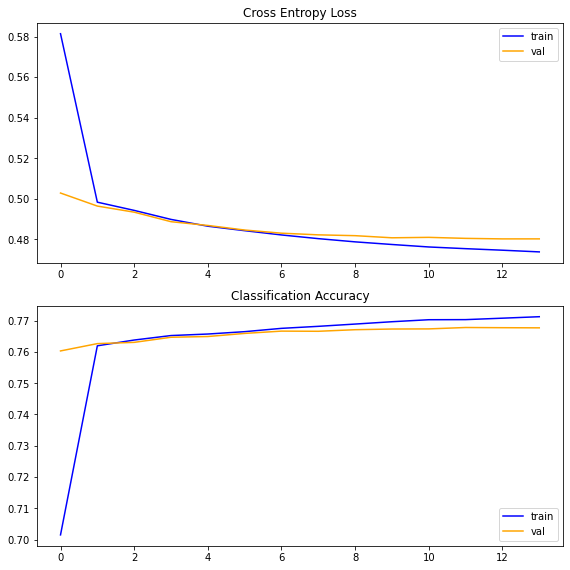

In [89]:
summarize_diagnostics(history_PP3s)

### Affichons les scores du modèle

In [90]:
t0 = time.perf_counter()
y_preds_proba = model_PP3s.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS03_simple + Tokenizer4500) -----------------------------------------------

             ROC_AUC : 0.8445
                  F1 : 0.7635
            ACCURACY : 0.7647
           PRECISION : 0.7627
              RECALL : 0.7643
   AVERAGE_PRECISION : 0.8371

       TRAINING-TIME : 702.9372
      INFERENCE-TIME : 23.9208

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.77      0.77    146176
Prediction = 1       0.76      0.76      0.76    144383

      accuracy                           0.76    290559
     macro avg     

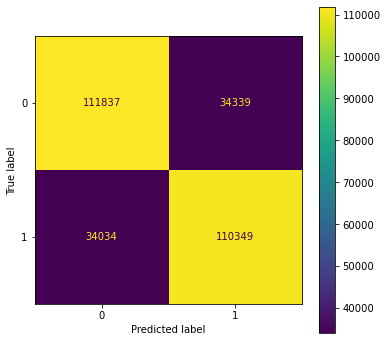

--- ROC AUC ---------------------------------------------------------------------------------------- 



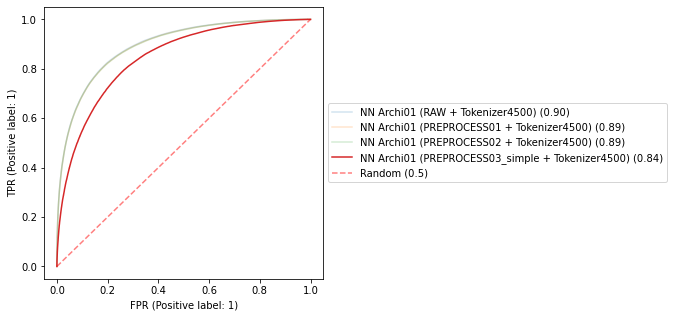

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



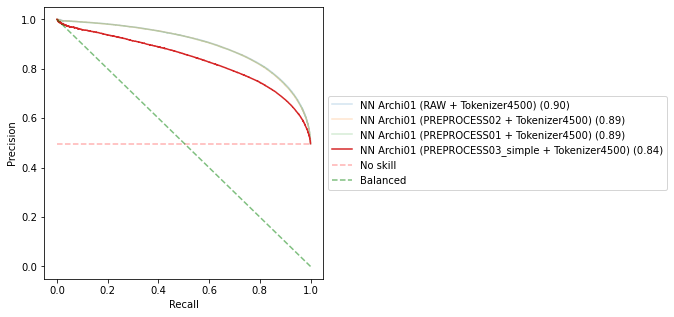

In [91]:
model_name = "NN Archi01 (PREPROCESS03_simple + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.5 Preprocessing 04 / SpaCy Lemmatization <a class="anchor" id="PREPROCESS_04"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_03) que l'on a Lemmatisé en utilisant SpaCy.

### Chargeons le jeu de données

In [92]:
display(data_preprocess_04.head(2), data_preprocess_04.shape)

,target,lemmas_filtered_advanced
0,0,bummer shoulda get day d
1,0,upset update facebook texte cry result school ...


(1452791, 2)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04['lemmas_filtered_advanced'], data_preprocess_04.target, test_size=0.2, random_state=random_seed)

In [94]:
display(X_train.head(2), X_train.shape)

317722    fake disguise link
37615         boss mad guess
Name: lemmas_filtered_advanced, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [95]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: fake disguise link

>> Tokenized sentence: ['fake link']

>> X_train_enc: [[1124, 296]]

>> X_train_ready: [[1124  296    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 178817


### Entrainons notre modèle

In [96]:
history_PP4, model_PP4, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP4")

--------------------------------------TESTING MODEL WITH "PP4"--------------------------------------

Epoch 1/50
142/142 [==============================] - 51s 344ms/step - loss: 0.6375 - accuracy: 0.6371 - val_loss: 0.5086 - val_accuracy: 0.7555

Epoch 00001: val_accuracy improved from -inf to 0.75554, saving model to models/archi01_PREPROCESS_PP4.epoch01-accuracy0.76.hdf5
Epoch 2/50
142/142 [==============================] - 48s 337ms/step - loss: 0.5045 - accuracy: 0.7575 - val_loss: 0.5024 - val_accuracy: 0.7571

Epoch 00002: val_accuracy improved from 0.75554 to 0.75714, saving model to models/archi01_PREPROCESS_PP4.epoch02-accuracy0.76.hdf5
Epoch 3/50
142/142 [==============================] - 48s 335ms/step - loss: 0.4996 - accuracy: 0.7602 - val_loss: 0.4987 - val_accuracy: 0.7576

Epoch 00003: val_accuracy improved from 0.75714 to 0.75762, saving model to models/archi01_PREPROCESS_PP4.epoch03-accuracy0.76.hdf5
Epoch 4/50
142/142 [==============================] - 47s 335ms/ste

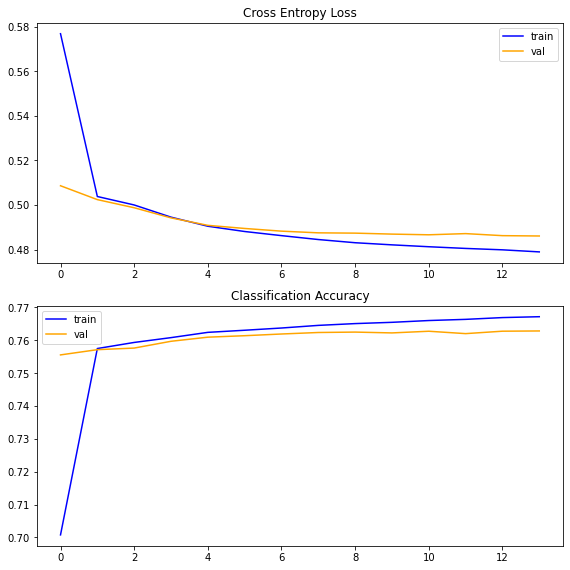

In [97]:
summarize_diagnostics(history_PP4)

### Affichons les scores du modèle

In [98]:
t0 = time.perf_counter()
y_preds_proba = model_PP4.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS04 + Tokenizer4500) ------------------------------------------------------

             ROC_AUC : 0.8408
                  F1 : 0.7536
            ACCURACY : 0.7597
           PRECISION : 0.7682
              RECALL : 0.7396
   AVERAGE_PRECISION : 0.8343

       TRAINING-TIME : 675.1467
      INFERENCE-TIME : 23.9668

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.75      0.78      0.77    146176
Prediction = 1       0.77      0.74      0.75    144383

      accuracy                           0.76    290559
     macro avg     

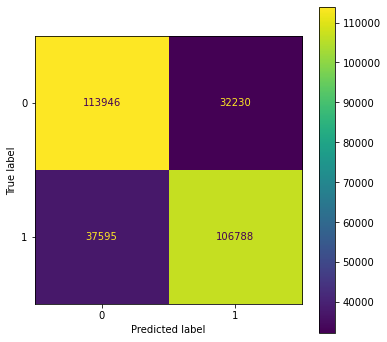

--- ROC AUC ---------------------------------------------------------------------------------------- 



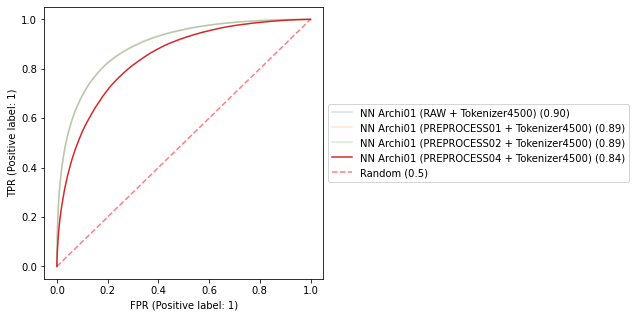

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



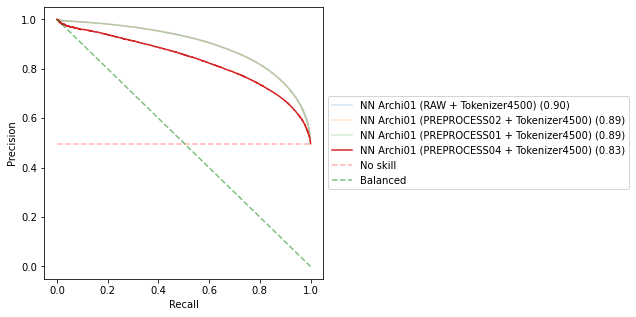

In [99]:
model_name = "NN Archi01 (PREPROCESS04 + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Testons la même chose avec le jeu de données qui a été filtré avec des règles plus simples

### Chargeons le jeu de données

In [100]:
display(data_preprocess_04_simple.head(2), data_preprocess_04_simple.shape)

,target,lemmas_filtered_simple
0,0,bummer shoulda get day d
1,0,upset update facebook texte cry result school ...


(1452791, 2)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04_simple['lemmas_filtered_simple'], data_preprocess_04_simple.target, test_size=0.2, random_state=random_seed)

In [102]:
display(X_train.head(2), X_train.shape)

317722    fake disguise link
37615         boss mad guess
Name: lemmas_filtered_simple, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [103]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: fake disguise link

>> Tokenized sentence: ['fake link']

>> X_train_enc: [[1133, 300]]

>> X_train_ready: [[1133  300    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 179781


### Entrainons notre modèle

In [104]:
history_PP4s, model_PP4s, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP4s")

-------------------------------------TESTING MODEL WITH "PP4S"--------------------------------------

Epoch 1/50
142/142 [==============================] - 50s 337ms/step - loss: 0.6460 - accuracy: 0.6231 - val_loss: 0.5076 - val_accuracy: 0.7562

Epoch 00001: val_accuracy improved from -inf to 0.75616, saving model to models/archi01_PREPROCESS_PP4s.epoch01-accuracy0.76.hdf5
Epoch 2/50
142/142 [==============================] - 47s 334ms/step - loss: 0.5031 - accuracy: 0.7591 - val_loss: 0.4994 - val_accuracy: 0.7588

Epoch 00002: val_accuracy improved from 0.75616 to 0.75880, saving model to models/archi01_PREPROCESS_PP4s.epoch02-accuracy0.76.hdf5
Epoch 3/50
142/142 [==============================] - 48s 335ms/step - loss: 0.4961 - accuracy: 0.7623 - val_loss: 0.4956 - val_accuracy: 0.7598

Epoch 00003: val_accuracy improved from 0.75880 to 0.75981, saving model to models/archi01_PREPROCESS_PP4s.epoch03-accuracy0.76.hdf5
Epoch 4/50
142/142 [==============================] - 47s 334ms/

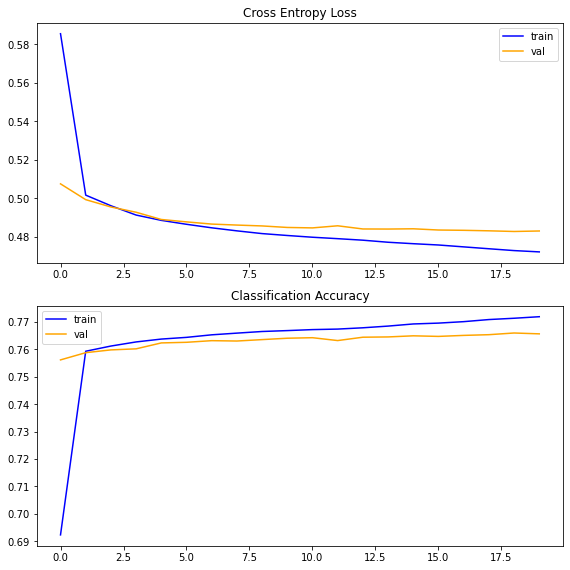

In [105]:
summarize_diagnostics(history_PP4s)

### Affichons les scores du modèle

In [106]:
t0 = time.perf_counter()
y_preds_proba = model_PP4s.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS04_simple + Tokenizer4500) -----------------------------------------------

             ROC_AUC : 0.8461
                  F1 : 0.7634
            ACCURACY : 0.7641
           PRECISION : 0.7608
              RECALL : 0.7660
   AVERAGE_PRECISION : 0.8405

       TRAINING-TIME : 960.9685
      INFERENCE-TIME : 24.1191

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.76      0.76    146176
Prediction = 1       0.76      0.77      0.76    144383

      accuracy                           0.76    290559
     macro avg     

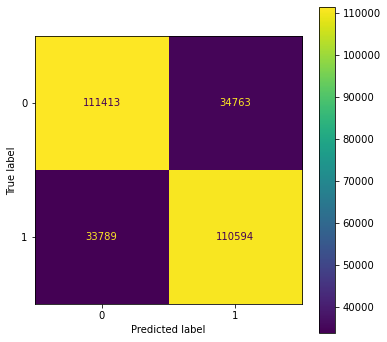

--- ROC AUC ---------------------------------------------------------------------------------------- 



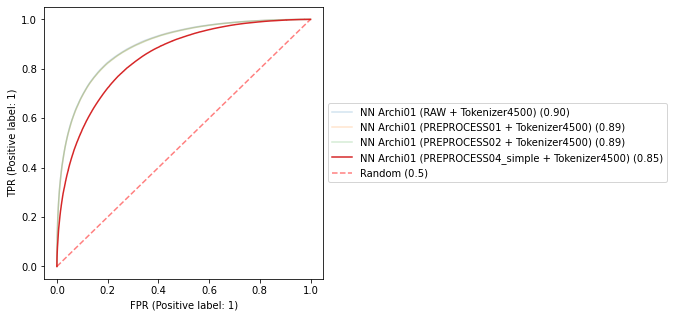

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



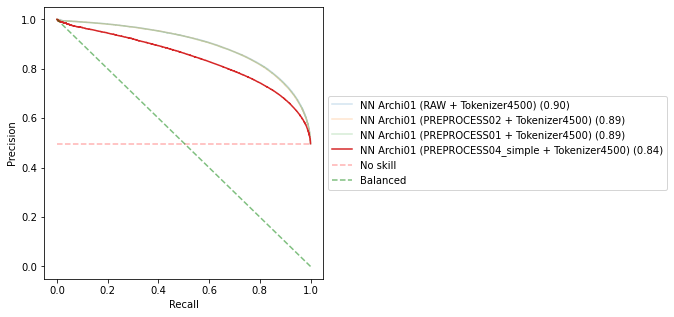

In [107]:
model_name = "NN Archi01 (PREPROCESS04_simple + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Testons la même chose avec le jeu de données qui n'a pas été filtré

### Chargeons le jeu de données

In [108]:
display(data_preprocess_04_nofilter.head(2), data_preprocess_04_nofilter.shape)

,target,lemmas_not_filtered
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...


(1452791, 2)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04_nofilter['lemmas_not_filtered'], data_preprocess_04_nofilter.target, test_size=0.2, random_state=random_seed)

In [110]:
display(X_train.head(2), X_train.shape)

317722    you too be fake .. :x ... disguise your link t...
37615                   my boss be still mad from I I guess
Name: lemmas_not_filtered, dtype: object

(1162232,)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [111]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test)

----- One sample outputs for demo -----
>> Original sentence: you too be fake .. :x ... disguise your link to be something else .

>> Tokenized sentence: ['you too be fake x your link to be something else']

>> X_train_enc: [[10, 46, 2, 1411, 197, 44, 456, 3, 2, 199, 447]]

>> X_train_ready: [[  10   46    2 1411  197   44  456    3    2  199  447    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 228026


### Entrainons notre modèle

In [112]:
history_PP4nof, model_PP4nof, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, "PP4nof")

------------------------------------TESTING MODEL WITH "PP4NOF"-------------------------------------

Epoch 1/50
142/142 [==============================] - 54s 364ms/step - loss: 0.6291 - accuracy: 0.6398 - val_loss: 0.4690 - val_accuracy: 0.7882

Epoch 00001: val_accuracy improved from -inf to 0.78820, saving model to models/archi01_PREPROCESS_PP4nof.epoch01-accuracy0.79.hdf5
Epoch 2/50
142/142 [==============================] - 51s 360ms/step - loss: 0.4644 - accuracy: 0.7896 - val_loss: 0.4557 - val_accuracy: 0.7924

Epoch 00002: val_accuracy improved from 0.78820 to 0.79239, saving model to models/archi01_PREPROCESS_PP4nof.epoch02-accuracy0.79.hdf5
Epoch 3/50
142/142 [==============================] - 51s 362ms/step - loss: 0.4499 - accuracy: 0.7948 - val_loss: 0.4431 - val_accuracy: 0.7944

Epoch 00003: val_accuracy improved from 0.79239 to 0.79440, saving model to models/archi01_PREPROCESS_PP4nof.epoch03-accuracy0.79.hdf5
Epoch 4/50
142/142 [==============================] - 51s 

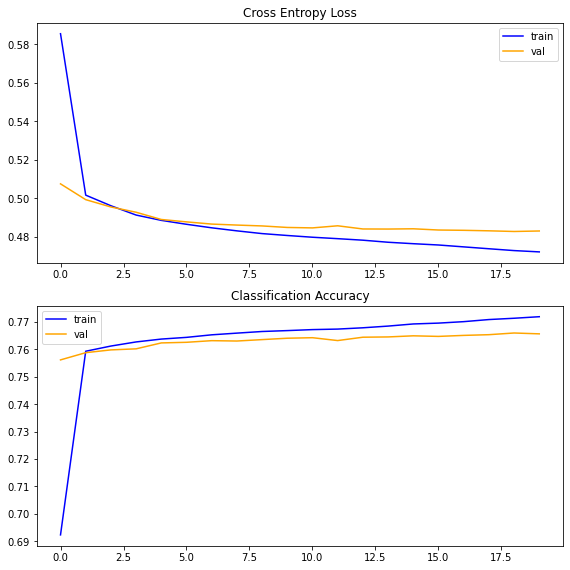

In [113]:
summarize_diagnostics(history_PP4s)

### Affichons les scores du modèle

In [114]:
t0 = time.perf_counter()
y_preds_proba = model_PP4nof.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PREPROCESS04_nofilter + Tokenizer4500) ---------------------------------------------

             ROC_AUC : 0.8963
                  F1 : 0.8145
            ACCURACY : 0.8140
           PRECISION : 0.8073
              RECALL : 0.8219
   AVERAGE_PRECISION : 0.8970

       TRAINING-TIME : 1400.8687
      INFERENCE-TIME : 24.2918

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.82      0.81      0.81    146176
Prediction = 1       0.81      0.82      0.81    144383

      accuracy                           0.81    290559
     macro avg    

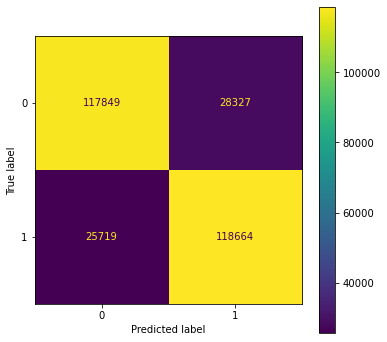

--- ROC AUC ---------------------------------------------------------------------------------------- 



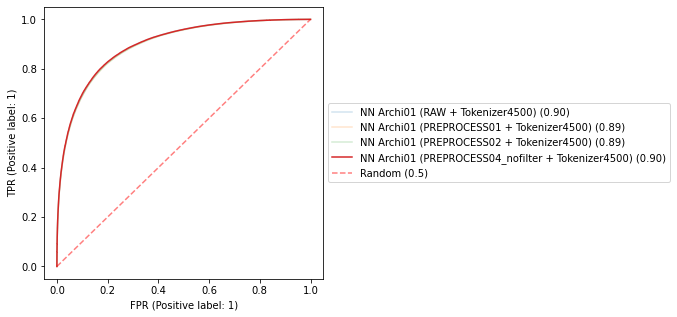

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



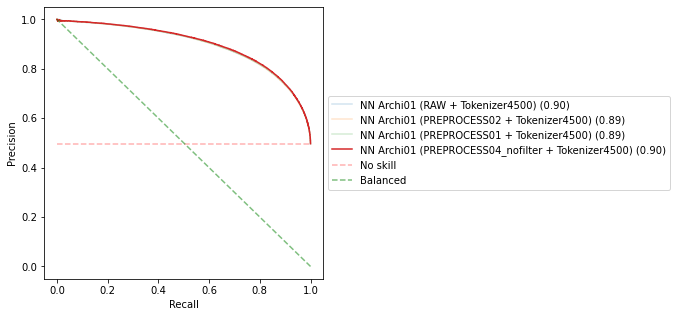

In [115]:
model_name = "NN Archi01 (PREPROCESS04_nofilter + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.6 Comparaison des `scores` avec les différents pré-traitements <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [116]:
from classification_utils import scores_df

In [117]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + Tokenizer4500),None,None,0.895449,0.895788,0.810211,0.812912,0.816891,0.803640,116032,120167,26009,28351,2231.321571,23.848580
1,NN Archi01 (PREPROCESS02 + Tokenizer4500),None,None,0.893776,0.894558,0.808913,0.811426,0.814675,0.803232,115973,119794,26382,28410,1195.012966,24.195830
2,NN Archi01 (PREPROCESS01 + Tokenizer4500),None,None,0.894032,0.894516,0.808555,0.811642,0.816821,0.800454,115572,120258,25918,28811,1195.012966,23.674459
3,NN Archi01 (PREPROCESS03 + Tokenizer4500),None,None,0.845024,0.838093,0.764767,0.764568,0.759442,0.770167,111199,110953,35223,33184,745.887899,23.932140
4,NN Archi01 (PREPROCESS03_simple + Tokenizer4500),None,None,0.844488,0.837100,0.763473,0.764685,0.762669,0.764280,110349,111837,34339,34034,702.937229,23.920813
5,NN Archi01 (PREPROCESS04 + Tokenizer4500),None,None,0.840828,0.834334,0.753618,0.759687,0.768160,0.739616,106788,113946,32230,37595,675.146728,23.966787
6,NN Archi01 (PREPROCESS04_simple + Tokenizer4500),None,None,0.846138,0.840522,0.763402,0.764069,0.760844,0.765977,110594,111413,34763,33789,960.968502,24.119112
7,NN Archi01 (PREPROCESS04_nofilter + Tokenizer4...,None,None,0.896341,0.896997,0.814513,0.813993,0.807288,0.821870,118664,117849,28327,25719,1400.868720,24.291804


>#### **Conclusion**:
> La meilleur option semble être `PREPROCESS04_nofilter` c'est à dire les textes préparés mais sans filtrage *(donc sans retirer les stopwords qui peuvent changer le sens du sentiment comme NOT)*